## 2018 Kaggle Data Science Survey

### Meet the data 

### The data set is selected from kaggle. The topic for our python project is "2018 Kaggle for ML and DS". The python programming has been done to explore more about the data.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import numpy as np
import statsmodels.api as sm
import pylab
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Survey data
MCR = pd.read_csv('multipleChoiceResponses.csv')
FFR = pd.read_csv('freeFormResponses.csv')

In [5]:
# CPI data
CPI2018 = pd.read_csv('CPI2018.csv')
cpi = CPI2018[['Country','Last']].rename(columns={"Last": "CPI"})

In [6]:
MCR.shape
FFR.shape
cpi.shape

(23860, 395)

(23860, 35)

(177, 2)

### Data Cleaning

In [7]:
# extract the questions from the dataset
questions_M = MCR.iloc[0,:]
questions_M

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                What is your gender? - Selected Choice
Q1_OTHER_TEXT                          What is your gender? - Prefer to self-describe...
Q2                                                           What is your age (# years)?
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
Q5                                     Which best describes your undergraduate major?...
Q6                                     Select the title most similar to your current ...
Q6_OTHER_TEXT                          Select the title most similar to your current ...
Q7                                     In what industry is your current employer/cont...
Q7_OTHER_TEXT                          In what industry is your current employer/cont...
Q8                   

In [8]:
questions_F = FFR.iloc[0,:]

In [9]:
MCR.drop([0],inplace=True)

In [10]:
FFR.drop([0],inplace=True)

In [11]:
# merge the CPI data with survey data by country name
MCR = MCR.merge(cpi,how='left',left_on='Q3',right_on='Country')
MCR.drop(columns=['Country'],inplace=True)

In [12]:
# backup the raw data, bcs for some specific analysis we would prefer using the original form of the attribute
MCR_original = MCR.copy()

### Feature Engineering

In [13]:
MCR['Q1'] = MCR.Q1.apply(lambda x: 0 if x=='Female' else 1 if x=='Male' \
             else 2)

In [14]:
MCR['Q2'] = MCR.Q2.apply(lambda x: 19.5 if x== '18-21' else 23 if x=='22-24' \
                         else 27 if x=='25-29' else 32 if x=='30-34'\
                         else 37 if x=='35-39' else 42 if x=='40-44'\
                         else 47 if x=='45-49' else 52 if x=='50-54'\
                         else 57 if x=='55-59' else 64.5 if x=='60-69'\
                         else 74.5 if x=='70-79' else 80 )

In [15]:
MCR = pd.get_dummies(MCR, columns=['Q3'])
MCR = pd.get_dummies(MCR, columns=['Q4'])
MCR = pd.get_dummies(MCR, columns=['Q5'])
MCR = pd.get_dummies(MCR, columns=['Q6'])
MCR = pd.get_dummies(MCR, columns=['Q7'])

In [16]:
MCR['Q8'] = MCR.Q8.apply(lambda x: 0.5 if x== '0-1' else 1.5 if x=='1-2' \
                         else 2.5 if x=='2-3' else 3.5 if x=='3-4'\
                         else 4.5 if x=='4-5' else 7.5 if x=='5-10'\
                         else 12.5 if x=='10-15' else 17.5 if x=='15-20'\
                         else 22.5 if x=='20-25' else 27.5 if x=='25-30'\
                         else 30 if x=='30 +' else None )

Q9 (yearly compensation) is an important feature in this project, also it will be the Y for supervised machine learning 

In [17]:
MCR['compensation'] = MCR.Q9.apply(lambda x: 5000 if x== '0-10,000' else 15000 if x=='10-20,000'\
                                   else 25000 if x=='20-30,000'\
                         else 35000 if x=='30-40,000' else 45000 if x=='40-50,000'\
                         else 55000 if x=='50-60,000' else 65000 if x=='60-70,000'\
                         else 75000 if x=='70-80,000' else 85000 if x=='80-90,000'\
                         else 95000 if x=='90-100,000' else 112500 if x=='100-125,000'\
                         else 137500 if x=='125-150,000' else 175000 if x=='150-200,000'\
                         else 225000 if x=='200-250,000' else 275000 if x=='250-300,000'\
                         else 350000 if x=='300-400,000' else 450000 if x=='400-500,000'\
                         else 550000 if x=='500,000+' else None)

However the compensation value is in USD unit for the whole dataset, while the same amount of compensation in different countries might mean different values in life. That's the reason we include the CPI data of 2018 to get a reference on the consuming capicity with the compensation in the respondent's country. The consuming capicity is defined as: 


Consuming Capicity = Compensation/CPI

In [18]:
# Generate a new variable to denote the consuming capicity of the respondent according 
# to his salary and the country he lives
MCR['consumingCapicity'] = MCR.compensation/MCR.CPI

In [19]:
# drop the rows where compensation is null 
# (they will be only dropped from this dataset which is prepared for ML models, 
# they are still kept in another original dataset called 'MCR_original')
MCR.compensation.isna().sum()
MCR = MCR.dropna(how='any',subset=['compensation'])

8430

In [20]:
# for consuming capicity, fill the null value with average
MCR.consumingCapicity.isna().sum()
MCR.consumingCapicity.fillna(value=MCR.consumingCapicity.mean(), inplace=True)

825

In [21]:
MCR = pd.get_dummies(MCR, columns=['Q10'])

In [22]:
# remove the free form responses columns
modelColumn = list(MCR.columns)
selectedCol = [col for col in modelColumn if 'OTHER' not in col]
len(modelColumn)
len(selectedCol)

516

486

In [23]:
MCR_model = MCR[selectedCol]

In [24]:
# Transform the original dummy variables into the standard form (0 and 1)
listcol = []
for col in list(MCR_model.columns):
    if MCR_model[col].nunique() == 1:
        listcol.append(col)
listcol.remove('Q6_Not employed')

In [25]:
for col in listcol:
    MCR_model = pd.get_dummies(MCR_model, columns=[col])

In [26]:
# check all the columns still have null values
nullcheck = MCR_model.isna().sum()
nullval = nullcheck[nullcheck != 0]
nullval

Q8                        76
Q12_MULTIPLE_CHOICE     1572
Q17                     4341
Q18                     1822
Q20                     5769
Q22                     6243
Q23                     1968
Q24                     1988
Q25                     2014
Q26                     2023
Q32                     5125
Q34_Part_1              3664
Q34_Part_2              3664
Q34_Part_3              3664
Q34_Part_4              3664
Q34_Part_5              3664
Q34_Part_6              3664
Q35_Part_1              3785
Q35_Part_2              3785
Q35_Part_3              3785
Q35_Part_4              3785
Q35_Part_5              3785
Q35_Part_6              3785
Q37                     8140
Q38_Part_19            15429
Q38_Part_20            15429
Q39_Part_1              3699
Q39_Part_2              3699
Q40                     3763
Q41_Part_1              4352
Q41_Part_2              4352
Q41_Part_3              4352
Q43                     5575
Q46                     5431
Q47_Part_16   

In [27]:
# deal with the null values
MCR_model = MCR_model.dropna(how='any',subset=['Q8'])
MCR_model['Q23'] = MCR_model.Q23.apply(lambda x: 13 if x == '1% to 25% of my time' \
                                       else 37 if x=='25% to 49% of my time' \
                                       else 63 if x=='50% to 74% of my time' \
                                       else 87 if x=='75% to 99% of my time'\
                                       else 100 if x=='100% of my time' else 0)
MCR_model['Q24'] = MCR_model.Q24.apply(lambda x: 1 if x == '< 1 year' \
                                       else 1.5 if x=='1-2 years' \
                                       else 4 if x=='3-5 years' \
                                       else 7.5 if x=='5-10 years'\
                                       else 15 if x=='10-20 years'\
                                       else 25 if x=='20-30 years' \
                                       else 35 if x=='30-40 years'\
                                       else 45 if x=='40+ years' \
                                       else 0)
MCR_model['Q25'] = MCR_model.Q25.apply(lambda x: 1 if x == '< 1 year' \
                                       else 1.5 if x=='1-2 years' \
                                       else 2.5 if x=='2-3 years' \
                                       else 3.5 if x=='3-4 years'\
                                       else 4.5 if x=='4-5 years'\
                                       else 7.5 if x=='5-10 years' \
                                       else 12.5 if x=='10-15 years'\
                                       else 20 if x=='20+ years' \
                                       else 0)
MCR_model['Q43'] = MCR_model.Q43.apply(lambda x: 0 if x == '0' \
                                       else 5 if x=='0-10' \
                                       else 15 if x=='10-20' \
                                       else 25 if x=='20-30'\
                                       else 35 if x=='30-40'\
                                       else 45 if x=='40-50' \
                                       else 55 if x=='50-60'\
                                       else 65 if x=='60-70' \
                                       else 75 if x=='70-80' \
                                       else 85 if x=='80-90'\
                                       else 95 if x=='90-100' \
                                       else 0)
MCR_model['Q46'] = MCR_model.Q46.apply(lambda x: 0 if x == '0' \
                                       else 5 if x=='0-10' \
                                       else 15 if x=='10-20' \
                                       else 25 if x=='20-30'\
                                       else 35 if x=='30-40'\
                                       else 45 if x=='40-50' \
                                       else 55 if x=='50-60'\
                                       else 65 if x=='60-70' \
                                       else 75 if x=='70-80' \
                                       else 85 if x=='80-90'\
                                       else 95 if x=='90-100' \
                                       else 0)
MCR_model.Q34_Part_1.fillna(0,inplace=True)
MCR_model.Q34_Part_2.fillna(0,inplace=True)
MCR_model.Q34_Part_3.fillna(0,inplace=True)
MCR_model.Q34_Part_4.fillna(0,inplace=True)
MCR_model.Q34_Part_5.fillna(0,inplace=True)
MCR_model.Q34_Part_6.fillna(0,inplace=True)
MCR_model.Q35_Part_1.fillna(0,inplace=True)
MCR_model.Q35_Part_2.fillna(0,inplace=True)
MCR_model.Q35_Part_3.fillna(0,inplace=True)
MCR_model.Q35_Part_4.fillna(0,inplace=True)
MCR_model.Q35_Part_5.fillna(0,inplace=True)
MCR_model.Q35_Part_6.fillna(0,inplace=True)

In [28]:
MCR_model.dropna(thresh=10000, axis=1, inplace=True)

In [29]:
nullcheck = MCR_model.isna().sum()
nullval = nullcheck[nullcheck != 0]
nullval

Q12_MULTIPLE_CHOICE    1560
Q17                    4318
Q18                    1808
Q26                    2009
Q32                    5094
Q39_Part_1             3675
Q39_Part_2             3675
Q40                    3739
Q41_Part_1             4325
Q41_Part_2             4325
Q41_Part_3             4325
CPI                     823
dtype: int64

In [30]:
# so far, the columns still containing null values are some category variables which are not going to be
# included in the model variables. However they are saved as another dataset for analysis later.
otherCategories = MCR_model[list(nullval.index)]
otherCategories.head()

Q12_MULTIPLE_CHOICE   Q17     Q18  \
1  Basic statistical software (Microsoft Excel, G...   NaN  Python   
2  Local or hosted development environments (RStu...  Java  Python   
4    Advanced statistical software (SPSS, SAS, etc.)   SQL       R   
6  Basic statistical software (Microsoft Excel, G...   NaN       R   
7  Local or hosted development environments (RStu...   NaN  Python   

              Q26               Q32       Q39_Part_1  \
1  Definitely not               NaN   Slightly worse   
2  Definitely yes  Time Series Data   Slightly worse   
4           Maybe               NaN  Slightly better   
6    Probably not    Numerical Data  Slightly better   
7    Probably not        Image Data  Slightly better   

                  Q39_Part_2  \
1  No opinion; I do not know   
2            Slightly better   
4                Much better   
6   Neither better nor worse   
7            Slightly better   

                                                 Q40            Q41_Part_1  \
1  Independent projects are equally important as ...                   NaN   
2  Independent projects are equally important as ...        Very important   
4  Independent projects are slightly more importa...  Not at all important   
6  Independent projects are much more important t...    Slightly important   
7  Independent projects are slightly more importa...        Very important   

           Q41_Part_2      Q41_Part_3     CPI  
1                 NaN             NaN  135.72  
2      Very important  Very important  252.67  
4  Slightly important  Very important  139.60  
6  Slightly important  Very important  100.79  
7      Very important  Very important  139.60

In [31]:
# all the other variables are selected for the use of building ML models
listcol2 = []
for col in list(MCR_model.columns):
    if MCR_model[col].isna().sum() == 0:
        listcol2.append(col)

In [32]:
len(listcol2)

467

In [33]:
# a column list for the machine learning models
listcol2.remove('Time from Start to Finish (seconds)')
listcol2.remove('Q9')
listcol2.remove('compensation')
listcol2.remove('consumingCapicity')

So far, we've had a clean dataset for building ML models.

### Exploratory Data Analysis

In [34]:
# function for generating donut plots
def donut_plot_general(label, value, layout_title,show_legend):
    trace=[go.Pie(
        values=value,
        labels = label,
        hoverinfo = 'label+percent',
        hole=.7,
        marker=dict(line=dict(color='black',width=.5)),
        textposition='outside'
    )]
    
    layout=go.Layout(
        title=layout_title,
        showlegend=show_legend
    )
    
    py.iplot({'data':trace, 'layout': layout}, filename='donut')

In [37]:
MCR_Q1 = MCR_original.groupby(['Q1']).size().reset_index(name='count')
donut_plot_general(MCR_Q1['Q1'], MCR_Q1['count'], 'Percentage of Gender',True)

In [36]:
MCR_Q4 = MCR_original.groupby(['Q4']).size().reset_index(name='count')
donut_plot_general(MCR_Q4['Q4'], MCR_Q4['count'], 'Percentage of Education',True)

In [38]:
MCR_Q3 = MCR_original.groupby(['Q3']).size().reset_index(name='count')
donut_plot_general(MCR_Q3['Q3'], MCR_Q3['count'], 'Percentage of Country',True)

In [39]:
MCR_Q6 = MCR_original.groupby(['Q6']).size().reset_index(name='count')
donut_plot_general(MCR_Q6['Q6'], MCR_Q6['count'], 'Percentage of Job Title',True)

In [40]:
MCR_Q7 = MCR_original.groupby(['Q7']).size().reset_index(name='count')
donut_plot_general(MCR_Q7['Q7'], MCR_Q7['count'], 'Percentage of Industry',True)

In [41]:
MCR_Q13_arr = np.array([MCR_original['Q13_Part_1'].value_counts().index, \
                                         MCR_original['Q13_Part_2'].value_counts().index, \
                                         MCR_original['Q13_Part_3'].value_counts().index, \
                                         MCR_original['Q13_Part_4'].value_counts().index, \
                                         MCR_original['Q13_Part_5'].value_counts().index, \
                                         MCR_original['Q13_Part_6'].value_counts().index, \
                                         MCR_original['Q13_Part_7'].value_counts().index, \
                                         MCR_original['Q13_Part_8'].value_counts().index, \
                                         MCR_original['Q13_Part_9'].value_counts().index, \
                                         MCR_original['Q13_Part_10'].value_counts().index, \
                                         MCR_original['Q13_Part_11'].value_counts().index, \
                                         MCR_original['Q13_Part_12'].value_counts().index, \
                                         MCR_original['Q13_Part_13'].value_counts().index, \
                                         MCR_original['Q13_Part_14'].value_counts().index, \
                                         MCR_original['Q13_Part_15'].value_counts().index])

MCR_Q13_index = pd.Series(map(lambda x: x[0], MCR_Q13_arr))


MCR_Q13_value_arr = np.array([MCR_original['Q13_Part_1'].value_counts().values, \
                                         MCR_original['Q13_Part_2'].value_counts().values, \
                                         MCR_original['Q13_Part_3'].value_counts().values, \
                                         MCR_original['Q13_Part_4'].value_counts().values, \
                                         MCR_original['Q13_Part_5'].value_counts().values, \
                                         MCR_original['Q13_Part_6'].value_counts().values, \
                                         MCR_original['Q13_Part_7'].value_counts().values, \
                                         MCR_original['Q13_Part_8'].value_counts().values, \
                                         MCR_original['Q13_Part_9'].value_counts().values, \
                                         MCR_original['Q13_Part_10'].value_counts().values, \
                                         MCR_original['Q13_Part_11'].value_counts().values, \
                                         MCR_original['Q13_Part_12'].value_counts().values, \
                                         MCR_original['Q13_Part_13'].value_counts().values, \
                                         MCR_original['Q13_Part_14'].value_counts().values, \
                                         MCR_original['Q13_Part_15'].value_counts().values])

MCR_Q13_value = pd.Series(map(lambda x: x[0], MCR_Q13_value_arr))
donut_plot_general(MCR_Q13_index, MCR_Q13_value, 'Percentage of IDE Usage', True)

In [42]:
input_data_tmp_Q19_index_arr = np.array([MCR_original['Q19_Part_1'].value_counts().index,\
                                         MCR_original['Q19_Part_2'].value_counts().index, \
                                         MCR_original['Q19_Part_3'].value_counts().index, \
                                         MCR_original['Q19_Part_4'].value_counts().index, \
                                         MCR_original['Q19_Part_5'].value_counts().index, \
                                         MCR_original['Q19_Part_6'].value_counts().index, \
                                         MCR_original['Q19_Part_7'].value_counts().index, \
                                         MCR_original['Q19_Part_8'].value_counts().index, \
                                         MCR_original['Q19_Part_9'].value_counts().index, \
                                         MCR_original['Q19_Part_10'].value_counts().index, \
                                         MCR_original['Q19_Part_11'].value_counts().index, \
                                         MCR_original['Q19_Part_12'].value_counts().index, \
                                         MCR_original['Q19_Part_13'].value_counts().index, \
                                         MCR_original['Q19_Part_14'].value_counts().index, \
                                         MCR_original['Q19_Part_15'].value_counts().index, \
                                         MCR_original['Q19_Part_16'].value_counts().index, \
                                         MCR_original['Q19_Part_17'].value_counts().index, \
                                         MCR_original['Q19_Part_18'].value_counts().index, \
                                         MCR_original['Q19_Part_19'].value_counts().index])
input_data_tmp_Q19_index = pd.Series(map(lambda x: x[0], input_data_tmp_Q19_index_arr))

input_data_tmp_Q19_value_arr = np.array([MCR_original['Q19_Part_1'].value_counts().values, \
                                         MCR_original['Q19_Part_2'].value_counts().values, \
                                         MCR_original['Q19_Part_3'].value_counts().values, \
                                         MCR_original['Q19_Part_4'].value_counts().values, \
                                         MCR_original['Q19_Part_5'].value_counts().values, \
                                         MCR_original['Q19_Part_6'].value_counts().values, \
                                         MCR_original['Q19_Part_7'].value_counts().values, \
                                         MCR_original['Q19_Part_8'].value_counts().values, \
                                         MCR_original['Q19_Part_9'].value_counts().values, \
                                         MCR_original['Q19_Part_10'].value_counts().values, \
                                         MCR_original['Q19_Part_11'].value_counts().values, \
                                         MCR_original['Q19_Part_12'].value_counts().values, \
                                         MCR_original['Q19_Part_13'].value_counts().values, \
                                         MCR_original['Q19_Part_14'].value_counts().values, \
                                         MCR_original['Q19_Part_15'].value_counts().values, \
                                         MCR_original['Q19_Part_16'].value_counts().values, \
                                         MCR_original['Q19_Part_17'].value_counts().values, \
                                         MCR_original['Q19_Part_18'].value_counts().values, \
                                         MCR_original['Q19_Part_19'].value_counts().values])
input_data_tmp_Q19_value = pd.Series(map(lambda x: x[0], input_data_tmp_Q19_value_arr))

donut_plot_general(input_data_tmp_Q19_index, input_data_tmp_Q19_value, 'Percentage of Machine Learning Framework usage', True)

In [43]:
# correlation matrix for all continuous variables
corcol = ['Q1','Q2','Q8','compensation','Q23','Q24','Q25','Q43','Q46','consumingCapicity']
corrdf = MCR_model[corcol].rename(index=str, columns={"Q1": "sex", "Q2": "age", "Q8": "experience",\
                                                     "Q23": "percentage of coding time","Q24": "coding experience",\
                                                      "Q25": "ML experience","Q43": "explore unfair bias",\
                                                      "Q46": "explore model insights"})

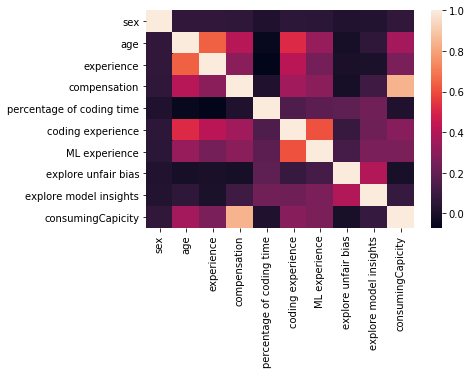

In [44]:
corr = corrdf.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In the heatmap above, the lighter color indicates a higher correlation coefficient. Age and working experience, coding experience and ML experience both have high correlation which is consistent with common sense. Otherwise, the compensation and consuming capictiy has the highest correlation coefficient, but they still have obvious difference, which will be covered later.

p.s. The matrix below is another heatmap for the correlation matrix with number on it. (The larger the absolute value of correlation coefficient is, the more red the background color is. All the other color pattern have been tried one by one, but they are all even harder to recognize)

In [45]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### *Finding #1: Respondents from undergraduate majors not directly related with DS (like fine arts or humanities) might have even better career development in data science area (and mostly not computer/tech industry)

To figure out what the most important factors of yearly compensation is, we start with gender.

In [46]:
MCR_original['compensation'] = MCR_original.Q9.apply(lambda x: 5000 if x== '0-10,000' else 15000 if x=='10-20,000'\
                                   else 25000 if x=='20-30,000'\
                         else 35000 if x=='30-40,000' else 45000 if x=='40-50,000'\
                         else 55000 if x=='50-60,000' else 65000 if x=='60-70,000'\
                         else 75000 if x=='70-80,000' else 85000 if x=='80-90,000'\
                         else 95000 if x=='90-100,000' else 112500 if x=='100-125,000'\
                         else 137500 if x=='125-150,000' else 175000 if x=='150-200,000'\
                         else 225000 if x=='200-250,000' else 275000 if x=='250-300,000'\
                         else 350000 if x=='300-400,000' else 450000 if x=='400-500,000'\
                         else 550000 if x=='500,000+' else None)

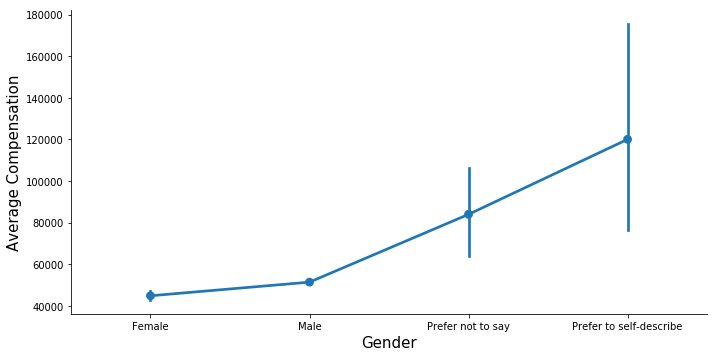

In [47]:
# Compare how different gender influence the average compensation
sns.factorplot(y='compensation', data=MCR_original, x='Q1',\
               aspect=2, kind='point').set_xlabels('Gender', fontsize= 15)\
                .set_ylabels('Average Compensation', fontsize= 15)


In [48]:
MCR_original.groupby('Q1')['compensation'].count()

Q1
Female                      2380
Male                       12866
Prefer not to say            130
Prefer to self-describe       53
Name: compensation, dtype: int64

The average compensation of 'Prefer not to say' and 'Prefer to self-describe' is much higher than others. Out of curiousity, the values of those self-describe genders are checked as below:

In [49]:
FFR.Q1_OTHER_TEXT.unique()

array([nan,
       'Male and female are sexes not gender. Gender is a regressive set of stereotypes associated with our sex. Ask what sex we are for demographic purposes, if that is what is important. ',
       'A little sunshine. :)', 'Kaggle', 'Transgender',
       'Attack helicopter', 'Human', 'Attack Helicopter', '18',
       'Barn owl', 'non-binary', 'Unicorn', 'Hetero flexible',
       'Nonbinary', 'Attack helicopter ', 'Non Binary', 'M', 'no binary',
       'Macho lady gaga', 'PANZER V TANK', 'shemale', 'Nunya', 'Ai',
       'unclear', 'mard', 'Agender', 'Bot', 'Your Highness',
       'my sex is male (no idea about "gender")', 'Transgender Female',
       'genderless', 'Female', 'Nonbinary (born female)', 'Testosterone',
       'bigender', 'Megatron', 'agender', 'XGBoost', 'attack helicopter',
       'Male', 'Transgender woman', 'Non-Binary', 'gaseous',
       'Who are you to insinuate I have a gender ?  ', 'Neutrois', 'NOYB',
       'Male Computer', 'bisexual',
       'Transgen

The first impression of seeing these values is that it seems like these people have more awareness on political issue and self-consciousness which a good data scientist should have. But also, some of the values show the respondent might be not serious about the survey, then the other respond might also be unreliable and be the noise in the data. Since the sample size of this group is small, we cannot get any conclusion from this view by now.

p.s. The 'Helicopter' appeared many times in the responds is actually a meme from the internet, which is a sarcasm on the current politcal correctness about the sex identification. ABC News once released a list of gender options which contains 58 different genders.

In [50]:
MCR_male = MCR_original[MCR_original.Q1 == 'Male']
MCR_female = MCR_original[MCR_original.Q1 == 'Female']

From the scale of the factorplot above, we cannot tell if the males' compensation is significantly higher than female, thus a statistical test is necessary. If we want to use t-test, the assumption is that the samples need to be normal distributed. QQ plot is done below.

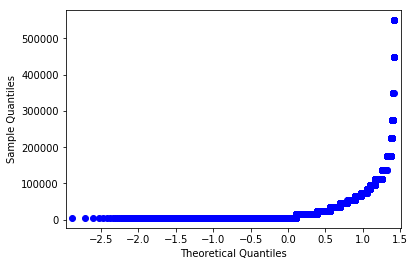

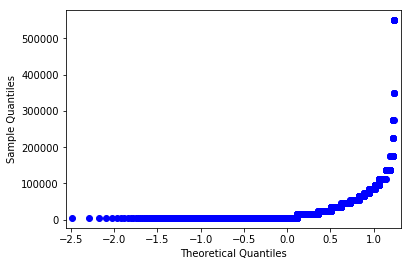

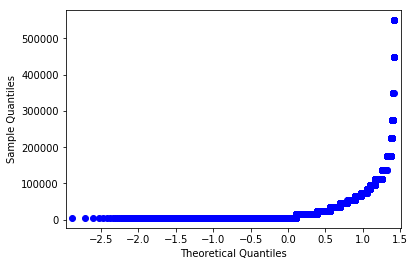

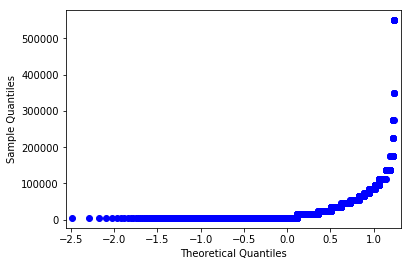

In [51]:
# check the qq plot to see if they are normal distributed
sm.qqplot(MCR_male.compensation, loc = 1, line='s')
sm.qqplot(MCR_female.compensation, loc = 1, line='s')
# apparently, they are not normal distributed, thus Wilcoxon rank sum test is used instead of t test

In [52]:
### (Wilcoxon) rank sum test 
scipy.stats.ranksums(MCR_male.compensation, MCR_female.compensation)

RanksumsResult(statistic=7.188831718920807, pvalue=6.534805542492327e-13)

P-value is much smaller than 0.05 which indicates the compensation of female is signficantly less than male. This might imply a sex discrimination in the area. However, since the data scope is limited and there is much less female included in the survey, we cannot tell if there really is apparent discrimination. More data and statistical test is required to get the answer.

The highest education is checked next:

In [53]:
MCR_original.groupby(['Q4']).compensation.agg({'size','mean'}).sort_values(by = 'mean',ascending = False)

size          mean
Q4                                                                     
No formal education past high school                  232  68555.555556
Doctoral degree                                      3357  67175.852498
I prefer not to answer                                345  54576.923077
Master’s degree                                     10855  52464.315125
Professional degree                                   599  43697.916667
Some college/university study without earning a...    967  40212.224109
Bachelor’s degree                                    7083  40185.375314

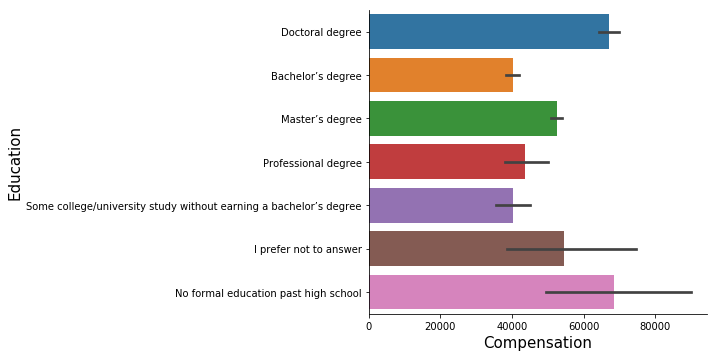

In [54]:
sns.factorplot(y='Q4', data=MCR_original, x='compensation',\
               aspect=2, kind='bar').set_xlabels('Compensation', fontsize= 15)\
                .set_ylabels('Education', fontsize= 15)

Except for the group of 'No formal education past high school' (which has a small sample size and might be biased), 'Doctoral degree' has the highest value with 'Master' and 'Bachelor' following. This is consistent with common sense. 

When it comes to the undergraduate major, something unexpected is found. The respondents from Computer Science major has a quite low rank in the list which is contradictory to our intuition. However, respondents from 'Fine arts or performing arts' and 'Humanities' are having the highest average compensation.

In [55]:
MCR_original.groupby(['Q5']).compensation.agg({'size','mean'}).sort_values(by = 'mean',ascending = False)

size           mean
Q5                                                                     
Fine arts or performing arts                          87  102584.745763
Humanities (history, literature, philosophy, etc.)   269   77523.809524
Physics or astronomy                                1110   66859.430605
Social sciences (anthropology, psychology, soci...   554   66265.133172
I never declared a major                             128   61654.411765
A business discipline (accounting, economics, f...  1791   60604.651163
Medical or life sciences (biology, chemistry, m...   871   57471.544715
Mathematics or statistics                           2950   55810.028930
Environmental science or geology                     253   55257.142857
Engineering (non-computer focused)                  3705   53310.044552
Other                                                770   51633.266533
Computer science (software engineering, etc.)       9430   41305.794172
Information technology, networking, or system a...  1029   36674.454829

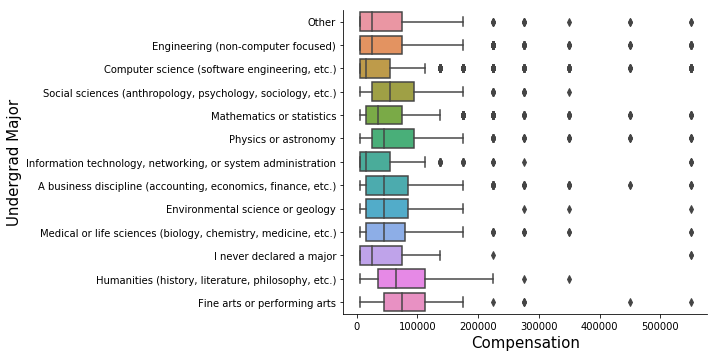

In [56]:
sns.factorplot(y='Q5', data=MCR_original, x='compensation',aspect=2, kind='box')\
                .set_xlabels('Compensation', fontsize= 15)\
                .set_ylabels('Undergrad Major', fontsize= 15)

In case there are more students (who might have very low compensation) in the group of Computer Science, the percentage of student is checked for both computer science and overall.

In [57]:
print('Percentage of Student in Computer Science:',MCR_original\
[(MCR_original.Q5 == 'Computer science (software engineering, etc.)') & (MCR_original.Q6 == 'Student')].\
compensation.count() / MCR_original[MCR_original.Q5 == 'Computer science (software engineering, etc.)'].\
compensation.count())
print('Percentage of Student Overall:',MCR_original[MCR_original.Q6 == 'Student'].\
compensation.count() / MCR_original.\
compensation.count())

Percentage of Student in Computer Science: 0.20987030486777833
Percentage of Student Overall: 0.16981009786765183


In [58]:
MCR_original[(MCR_original.Q5 == 'Computer science (software engineering, etc.)')\
             & (MCR_original.Q6 != 'Student')].compensation.mean()

49481.453847793644

It seems the percentage of students in computer science major is higher. Thus the average compensation of the non-student is checked. The result is still below $50,000 which is still below the average in the list.

To dig further, the heatmap in more dimensions is plotted as below. The darker color represents the higher compensation.

In [59]:
# function for generating heat map
def heat_map_general(x_label, y_label, z_value, layout_title):
    trace=[go.Heatmap(
        z=z_value,
        x = x_label,
        y = y_label,
        autocolorscale=True
    )]
    
    layout=go.Layout(
        title=layout_title
    )
    
    py.iplot({'data':trace, 'layout': layout}, filename='labelled-heatmap')

In [91]:
MCR_Q5_Q4 = MCR_original.groupby(['Q4','Q5']).compensation.mean().reset_index(name='count')
heat_map_general(np.array(MCR_Q5_Q4['Q5'].value_counts().index), np.array(MCR_Q5_Q4['Q4'].value_counts().index),\
                 np.array(np.round(pd.pivot_table(data=MCR_Q5_Q4, columns="Q5", index="Q4", aggfunc=np.sum))), \
                 'Compensation of different undergrad major and education level')

Except for the 'Other' group, the 'Fine arts or performing arts' with the highest education of Bachelor's degree have the highest average compensation. This means those people didn't get any further education after graduating from the undergraduate major. However, after they enter the data science area, they have a quite good career development.

The whole line of 'Humanities' is also having a dark color which indicates they are above the average.

In [96]:
MCR_Q5_Q7 = MCR_original.groupby(['Q5','Q7']).compensation.mean().reset_index(name='count')
heat_map_general(np.array(MCR_Q5_Q7['Q7'].unique()), np.array(MCR_Q5_Q7['Q5'].unique()),\
                 np.array(np.round(pd.pivot_table(data=MCR_Q5_Q7, columns="Q7", index="Q5", aggfunc=np.sum))), \
                 'Compensation of different undergrad major and industry')

The heatmap above shows the respondents from many non IT-related industry are actually earning more money than the 'Computers/Technology' industry

In [97]:
MCR_Q6_Q5 = MCR_original.groupby(['Q6','Q5']).compensation.mean().reset_index(name='count')
heat_map_general(np.array(MCR_Q6_Q5['Q6'].unique()), np.array(MCR_Q6_Q5['Q5'].unique()),\
                 np.array(np.round(pd.pivot_table(data=MCR_Q6_Q5, columns="Q6", index="Q5", aggfunc=np.sum))), \
                 'Compensation of different undergrad major and job title')

Obviously, respondents who are chief officers have the highest average compensations. Besides, principle investigators are also having high compensations.

Although the sample size of respondents from the top 2 majors is not large enough (Fine arts or performing arts:87, Humanities:269) which may lead to a bias in the analysis, we can still tell a trend according to the heatmaps above that the computer science major and computer related industries are not a gurantee of high compensation in the data science area. While many people with different background are entering the data science area and having a good career development.

### Managerial Insights

<div class="alert alert-block alert-info">
<br>
**  **
Using the above finding, we believe that it will be very beneficial for students with non computer focused majors to explore a job in data science related field too.


<br>
</div>

### *Finding #2: For experienced coders, AWS is best choice for Cloud Computing Services

Among the ML models, firstly, an unsupervised model is attempted to built to see if there is any characteristic in common for some of the data.

In [62]:
# K-Means Clusering
clu = KMeans(n_clusters=3)

In [63]:
listcol3 = listcol2.copy()
listcol3.append('compensation')
listcol3.append('consumingCapicity')

In [64]:
dd = MCR_model[listcol3]
clu.fit(dd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
dd['cluster'] = clu.labels_

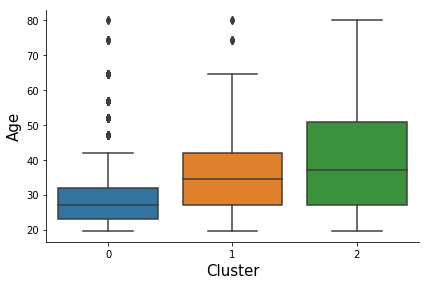

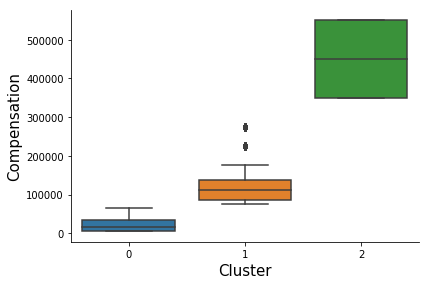

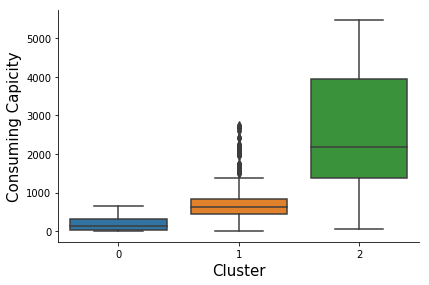

In [66]:
sns.factorplot(y='Q2', data=dd, x='cluster',\
               aspect=1.5, kind='box').set_ylabels('Age', fontsize= 15).set_xlabels('Cluster', fontsize= 15)
sns.factorplot(y='compensation', data=dd, x='cluster',\
               aspect=1.5, kind='box').set_xlabels('Cluster', fontsize= 15).set_ylabels('Compensation', fontsize= 15)
sns.factorplot(y='consumingCapicity', data=dd, x='cluster',\
               aspect=1.5, kind='box').set_xlabels('Cluster', fontsize= 15).set_ylabels('Consuming Capicity', fontsize= 15)

Text(0.5,0,'Age')

Text(0,0.5,'Compensation')

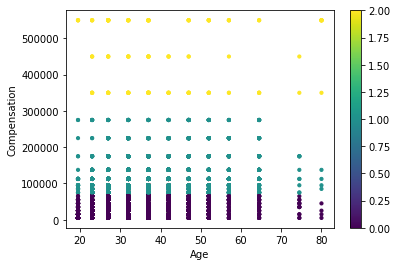

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(dd.Q2,dd.compensation,c=dd.cluster,s=10)
ax.set_xlabel('Age')
ax.set_ylabel('Compensation')
plt.colorbar(scatter)
fig.show()

According to the cluster labels given by the K-means clustering model, we can see Cluster 0 are the younger people with less experiences, Cluster 2 are the older people with more experiences, and Cluster 1 is in the middle. We can tell that definitely the respondents in the same cluster group have something in common. (The order of the clusters might change sometimes when run multiple times)

To go further, decision trees are built targeted on the compensation. In the first attempt, the compensation is splitted into 3 bins according to the common sense on compensation.

In [68]:
# Decision Tree 1

In [69]:
Y = MCR_model.compensation.apply(lambda x: 0 if x< 50000 else 2 if x>100000 else 1 )

In [70]:
X = MCR_model[listcol2]

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [72]:
dt = tree.DecisionTreeClassifier(max_depth=3)

In [73]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

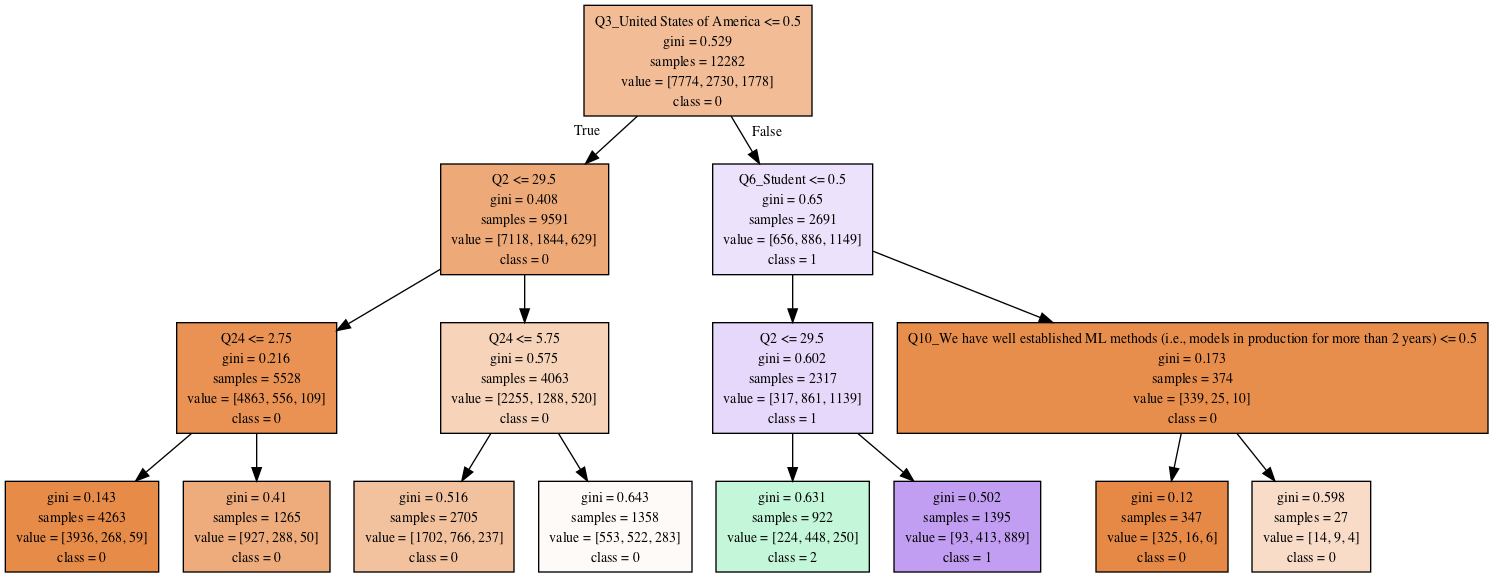

In [74]:
dt_feature_names = list(X_train.columns)
dt_target_names = [str(s) for s in Y_train.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [75]:
# accuracy of the training data 
(dt.predict(X_train) == Y_train).mean()
# accuracy of the test data 
(dt.predict(X_test) == Y_test).mean()

0.7160071649568475

0.7212634321068055

The accuracy of the decision tree on both train and test data is over 70% which are acceptable. 

The first interesting thing observed is that among the branches of the decision tree, only one is class = 2. This branch refers to people are: 
    1. From United States 
    2. Non-student 
    3. Less than 30 years old

This is contradictory to the intuition that older people earn more. 
However, when we observe deeper, it is strange to find actually among the US non-student people, still the older people have a higher average compensation. This means the decision tree might give us a wrong information. Also, if check the value list in the end of that branch, Class 1 is actually the largest class, instead of Class 2.

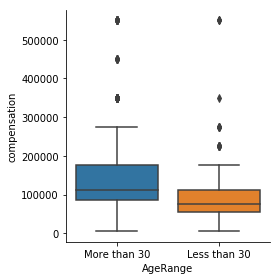

In [76]:
usNonStudent = MCR_model[(MCR_model['Q3_United States of America']==1)\
                       & (MCR_model.Q6_Student == 0)]
usNonStudent['AgeRange'] = MCR_model.Q2.apply(lambda x: 'Less than 30' if x<30 else 'More than 30')
sns.factorplot(x='AgeRange', y='compensation', data=usNonStudent,kind='box',aspect=1)

No matter we use the gini or entropy method, the same result of decision tree is given. If we dig into the algorithm of decision tree, it is found that, mathematically this would happen due to a bad situation of group splitting. Therefore this finding may not give us any practical meaningful information on the compensation.


Since the first node is whether the respondent is in United States, we are interested to know if United States is the important factor.

In [77]:
py.init_notebook_mode(connected=True)
def choropleth_map(map_key, map_value, color_scale, title, layout_title):
    data = [dict(type='choropleth',
               colorscale=color_scale,
               locations=map_key,
               locationmode='country names',
               z=map_value,
               text=map_key,
               colorbar={'title':title},
               marker=dict(line=dict(color='rgb(0,0,0)', width=0.4)))]
    
    layout = dict(title=layout_title,
                 geo=dict(showland=True,
                         landcolor='rgb(220,220,0)',
                         showcoastlines=True))
    
    py.iplot({'data':data, 'layout': layout}, filename='world-map')
    
choropleth_map(MCR_original.groupby('Q3').compensation.mean().index, MCR_original.groupby('Q3')\
.compensation.mean().values, 'Earth','Yearly Compensation', 'Yearly Compensation\
 of the respondents from different countries')

United Stataes do have the top average compensation according to the choropleth map.

p.s. We've tried different parameters of color, but found impossible to make them in one single color scheme. Please consider the scale just adjacent to the image. Countries with yearly comensation above "80K" is on the higher region. We see USA to fall in that category. Similiarly, the yearly compensation below "20K" is low. We see Egypt to fall in that category. 

In [78]:
MCR_original['consumingCapicity'] = MCR_original.compensation/MCR_original.CPI
choropleth_map(MCR_original.groupby('Q3').compensation.mean().index, MCR_original.groupby('Q3')\
.consumingCapicity.mean().values, 'Earth','Consuming Capicity', 'Consuming Capicity\
 of the respondents from different countries')

However, as we mentioned before, the compensation in different countries might have different consuming capicity in different countries due to its economy. Thus, the consuming capicity value is also checked. Surprisingly, in this map, the United States is only around the middle.

In [79]:
MCR_original.groupby('Q3').compensation.mean().nlargest(10)

Q3
Switzerland                                             99369.565217
United States of America                                98630.268199
Australia                                               86420.940171
Israel                                                  85100.806452
Hong Kong (S.A.R.)                                      71279.069767
Denmark                                                 69845.679012
Norway                                                  69811.320755
Canada                                                  69024.943311
Ireland                                                 66875.000000
United Kingdom of Great Britain and Northern Ireland    64959.595960
Name: compensation, dtype: float64

In [80]:
MCR_original.groupby('Q3').consumingCapicity.mean().nlargest(10)

Q3
Switzerland                                             977.469656
Israel                                                  840.917060
Australia                                               757.414024
Denmark                                                 680.094245
Ireland                                                 666.085657
Hong Kong (S.A.R.)                                      659.380849
Norway                                                  632.348920
United Kingdom of Great Britain and Northern Ireland    612.826377
Singapore                                               574.512640
Netherlands                                             561.349628
Name: consumingCapicity, dtype: float64

After check the particular number of the compensation and consuming capicity among different countries, we can see the United State have the second high average compensation.
But when it comes to consuming capicity, the US is not in the top 10. While, Switzerland is in the top 1 for both list.

Since the information from the first decision tree is quite limited and disappointing, more efforts are made to build more decision trees. The parameters are modified repeatedly and at last we get the following one.

In [81]:
# Decision Tree 2

In [82]:
Y = MCR_model.compensation.apply(lambda x: 0 if x< 5001 else 2 if x>75000 else 1 )
X = MCR_model[listcol2].drop(columns = ['Q6_Student','Q3_United States of America'])

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

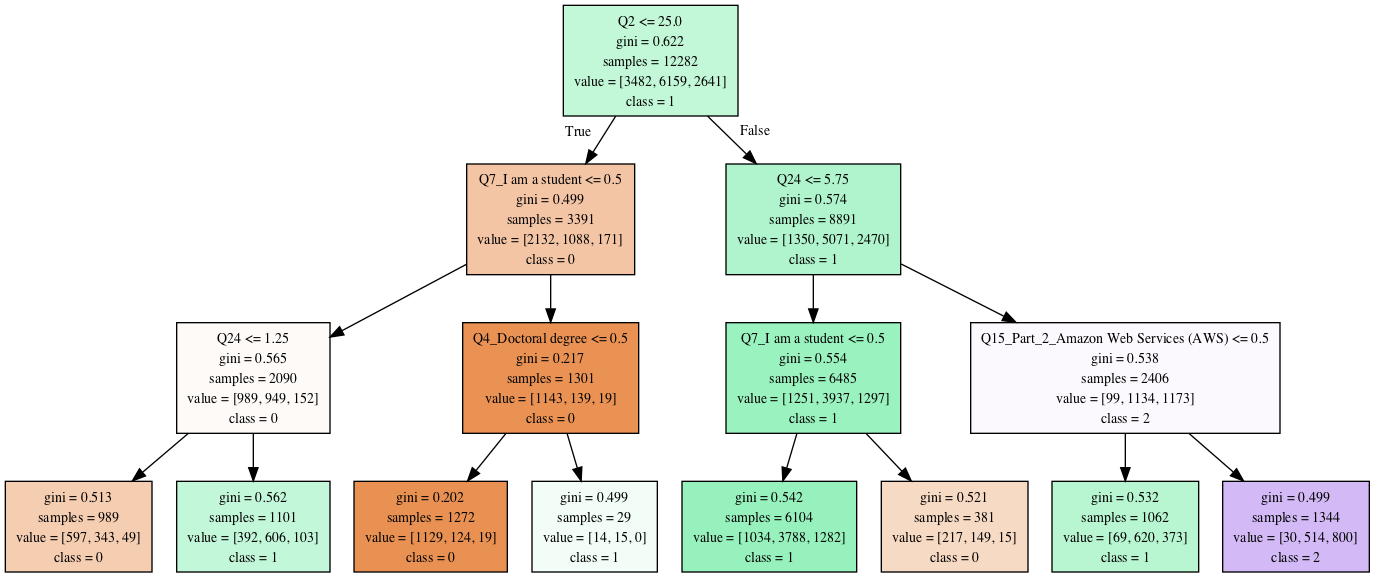

In [84]:
dt.fit(X_train,Y_train)
dt_feature_names = list(X_train.columns)
dt_target_names = [str(s) for s in Y_train.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In the last branch we can tell that respondents over 25 years old (Q2), having coding experience more than 5 years and using AWS have the highest average compensation. Then we are interested in dig deeper on the cloud computing services.

In [85]:
MCR_original_Q15_index_arr = np.array([MCR_original['Q15_Part_1'].value_counts().index,\
                                         MCR_original['Q15_Part_2'].value_counts().index, \
                                         MCR_original['Q15_Part_3'].value_counts().index, \
                                         MCR_original['Q15_Part_4'].value_counts().index, \
                                         MCR_original['Q15_Part_5'].value_counts().index, \
                                         MCR_original['Q15_Part_7'].value_counts().index])
MCR_original_Q15_index = pd.Series(map(lambda x:x[0], MCR_original_Q15_index_arr))

MCR_original_Q15_value_arr = np.array([MCR_original['Q15_Part_1'].value_counts().values,\
                                       MCR_original['Q15_Part_2'].value_counts().values, \
                                       MCR_original['Q15_Part_3'].value_counts().values, \
                                       MCR_original['Q15_Part_4'].value_counts().values, \
                                       MCR_original['Q15_Part_5'].value_counts().values, \
                                       MCR_original['Q15_Part_7'].value_counts().values])
MCR_original_Q15_value = pd.Series(map(lambda x:x[0], MCR_original_Q15_value_arr))

donut_plot_general(MCR_original_Q15_index, MCR_original_Q15_value, 'Percentage of Cloud Computing Service usage overall',\
                   True)

From the chart above, we can tell the most 3 popular cloud computing services are AWS, GCP and Microsoft Azure.

In [86]:
experiencedCoder = MCR_model[(MCR_model.Q2 > 25) & (MCR_model.Q24 > 5.75)]

In [87]:
nonExpCoder = MCR_model[(MCR_model.Q2 <= 25) | (MCR_model.Q24 <= 5.75)]

Text(0.5,0,'AWS Usage')

Text(0,0.5,'Compensation')

Text(0.5,1,'Compensation by AWS usage')

([<matplotlib.axis.XTick at 0x1c2bb166a0>,
 <a list of 2 Text xticklabel objects>)

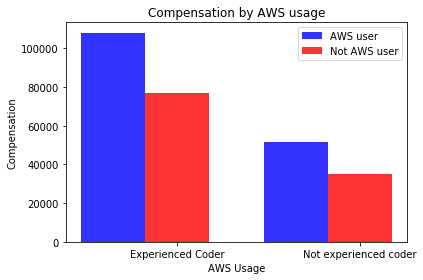

In [88]:
n_groups = 2
awsAvgComp = (experiencedCoder[experiencedCoder['Q15_Part_2_Amazon Web Services (AWS)'] == 1].compensation.mean(),\
            nonExpCoder[nonExpCoder['Q15_Part_2_Amazon Web Services (AWS)'] == 1].compensation.mean())
nonawsAvgComp = (experiencedCoder[experiencedCoder['Q15_Part_2_Amazon Web Services (AWS)'] == 0].compensation.mean(),\
            nonExpCoder[nonExpCoder['Q15_Part_2_Amazon Web Services (AWS)'] == 0].compensation.mean())
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, awsAvgComp, bar_width,
alpha=opacity,
color='b',
label='AWS user')
 
rects2 = plt.bar(index + bar_width, nonawsAvgComp, bar_width,
alpha=opacity,
color='r',
label='Not AWS user')
 
plt.xlabel('AWS Usage')
plt.ylabel('Compensation')
plt.title('Compensation by AWS usage')
plt.xticks(index + bar_width, ('Experienced Coder', 'Not experienced coder'))
plt.legend()
 
plt.tight_layout()
plt.show()

The graph above shows us among both experienced and not experienced coders, AWS users earn more than not AWS users. And the gap among experience coders are even larger.

<BarContainer object of 5 artists>

([<matplotlib.axis.XTick at 0x1c3f0a9390>,
 <a list of 5 Text xticklabel objects>)

Text(0,0.5,'Cloud Computing')

Text(0.5,1,'Average compensation of respondents using different clouding services among experience coders')

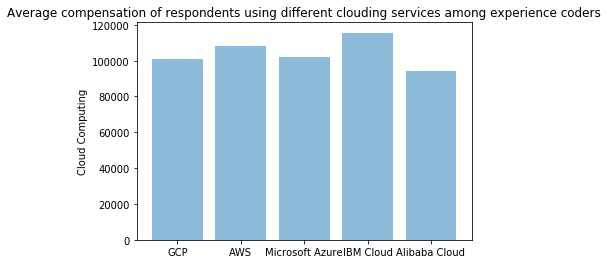

In [89]:
ecAvgCom = [experiencedCoder[experiencedCoder['Q15_Part_1_Google Cloud Platform (GCP)'] == 1].compensation.mean(),\
experiencedCoder[experiencedCoder['Q15_Part_2_Amazon Web Services (AWS)'] == 1].compensation.mean(),\
experiencedCoder[experiencedCoder['Q15_Part_3_Microsoft Azure'] == 1].compensation.mean(),\
experiencedCoder[experiencedCoder['Q15_Part_4_IBM Cloud'] == 1].compensation.mean(),\
experiencedCoder[experiencedCoder['Q15_Part_5_Alibaba Cloud'] == 1].compensation.mean()]
cloud = ('GCP','AWS','Microsoft Azure',\
         'IBM Cloud','Alibaba Cloud')
y_pos = np.arange(len(cloud))
plt.bar(y_pos, ecAvgCom, align='center', alpha=0.5)
plt.xticks(y_pos, cloud)
plt.ylabel('Cloud Computing')
plt.title('Average compensation of respondents using different clouding services among experience coders')
plt.show()

Among all respondents, the ones using IBM Cloud seems have the highest average compensation (AWS is second). However, the IBM Cloud users are only about 6% people among all, thus the AWS (which the most popular one) is still preferred.

### Managerial Insights

<div class="alert alert-block alert-info">
<br>
** 
If you are an experienced coder, and haven't used cloud computing service before, it will be better to start with AWS. And for those who are using other cloud computing services, it is worthwhile to consider using AWS as well. **


<br>
</div>


### *Finding #3: Python is the most polpular programming tool for non-computer related major people

Programming tool is another topic interest us to explore. The percentage of usage is checked first.

In [90]:
MCR_Q16_arr = np.array([MCR_original['Q16_Part_1'].value_counts().index, \
                        MCR_original['Q16_Part_2'].value_counts().index, \
                        MCR_original['Q16_Part_3'].value_counts().index, \
                        MCR_original['Q16_Part_4'].value_counts().index, \
                        MCR_original['Q16_Part_5'].value_counts().index, \
                        MCR_original['Q16_Part_6'].value_counts().index, \
                        MCR_original['Q16_Part_7'].value_counts().index, \
                        MCR_original['Q16_Part_8'].value_counts().index, \
                        MCR_original['Q16_Part_9'].value_counts().index, \
                        MCR_original['Q16_Part_10'].value_counts().index, \
                        MCR_original['Q16_Part_11'].value_counts().index, \
                        MCR_original['Q16_Part_12'].value_counts().index, \
                        MCR_original['Q16_Part_13'].value_counts().index, \
                        MCR_original['Q16_Part_14'].value_counts().index, \
                        MCR_original['Q16_Part_15'].value_counts().index, \
                        MCR_original['Q16_Part_16'].value_counts().index, \
                        MCR_original['Q16_Part_17'].value_counts().index, \
                        MCR_original['Q16_Part_18'].value_counts().index, ])

MCR_Q16_index = pd.Series(map(lambda x: x[0], MCR_Q16_arr))


MCR_Q16_value_arr = np.array([MCR_original['Q16_Part_1'].value_counts().values, \
                              MCR_original['Q16_Part_2'].value_counts().values, \
                              MCR_original['Q16_Part_3'].value_counts().values, \
                              MCR_original['Q16_Part_4'].value_counts().values, \
                              MCR_original['Q16_Part_5'].value_counts().values, \
                              MCR_original['Q16_Part_6'].value_counts().values, \
                              MCR_original['Q16_Part_7'].value_counts().values, \
                              MCR_original['Q16_Part_8'].value_counts().values, \
                              MCR_original['Q16_Part_9'].value_counts().values, \
                              MCR_original['Q16_Part_10'].value_counts().values, \
                              MCR_original['Q16_Part_11'].value_counts().values, \
                              MCR_original['Q16_Part_12'].value_counts().values, \
                              MCR_original['Q16_Part_13'].value_counts().values, \
                              MCR_original['Q16_Part_14'].value_counts().values, \
                              MCR_original['Q16_Part_15'].value_counts().values, \
                              MCR_original['Q16_Part_16'].value_counts().values, \
                              MCR_original['Q16_Part_17'].value_counts().values, \
                              MCR_original['Q16_Part_18'].value_counts().values, ])

MCR_Q16_value = pd.Series(map(lambda x: x[0], MCR_Q16_value_arr))
donut_plot_general(MCR_Q16_index, MCR_Q16_value, 'Percentage of Programming Language Usage Overall', True)

The top 3 is python, sql and r. The following analysis will focus on this 3

In [91]:
# Count the Programming Tool Usage by Age
MCR_original['Python_Count'] = MCR_original.Q16_Part_1.apply(lambda x: 1 if x == 'Python' else 0)
MCR_original['R_Count'] = MCR_original.Q16_Part_2.apply(lambda x: 1 if x == 'R' else 0)
MCR_original['SQL_Count'] = MCR_original.Q16_Part_3.apply(lambda x: 1 if x == 'SQL' else 0)
toolCount = MCR_original.groupby('Q2')[['Python_Count','R_Count','SQL_Count']].sum()
toolCount.reset_index(level=0, inplace=True)
python_C = toolCount.iloc[:,[0,1]].rename(columns={"Python_Count": "Count"})
r_C = toolCount.iloc[:,[0,2]].rename(columns={"R_Count": "Count"})
sql_C = toolCount.iloc[:,[0,3]].rename(columns={"SQL_Count": "Count"})
python_C['tool'] = 'Python'
r_C['tool'] = 'R'
sql_C['tool'] = 'SQL'
MCR_tool = python_C.append(r_C).append(sql_C)

In [92]:
# function for generate gruoped bar plot
def grouped_bar_plot(x_axis, y_axis1, y_axis2, y_axis3, x_layout_name, y_layout_name, layout_title, show_legend):
    trace1=go.Bar(
        x=x_axis,
        y=y_axis1,
        name="Python",
        marker=dict(color='#3D9970', line=dict(color='black',width=1))
    )

    trace2=go.Bar(
        x=x_axis,
        y=y_axis2,
        name="R",
        marker=dict(color='#FF4136', line=dict(color='black',width=1))
    )

    trace3=go.Bar(
        x=x_axis,
        y=y_axis3,
        name="SQL",
        marker=dict(color='#FF851B', line=dict(color='black',width=1))
    )

    data=[trace1,trace2,trace3]

    layout=go.Layout(
        xaxis=dict(title=x_layout_name),
        yaxis=dict(title=y_layout_name),
        title=layout_title,
        showlegend=show_legend,
        barmode='group'
    )

    py.iplot({'data': data, 'layout': layout}, filename='grouped-bar-direct-labels')

grouped_bar_plot(MCR_tool['Q2'].unique(), \
                                MCR_tool['Count'][MCR_tool['tool']=="Python"],\
                                MCR_tool['Count'][MCR_tool['tool']=="R"],\
                                MCR_tool['Count'][MCR_tool['tool']=="SQL"], \
                                'Age', 'Count', 'Count of Programming Tool Usage by Age', True)

In [93]:
# The rate of programming tools by education
toolEducation = MCR_original.groupby('Q4')[['Python_Count','R_Count','SQL_Count']].mean().\
sort_values(by='Python_Count', ascending = False)
toolEducation

Python_Count   R_Count  \
Q4                                                                           
Doctoral degree                                         0.732797  0.362526   
Professional degree                                     0.686144  0.348915   
Master’s degree                                         0.683648  0.324182   
Bachelor’s degree                                       0.647748  0.216716   
Some college/university study without earning a...      0.601861  0.154085   
I prefer not to answer                                  0.457971  0.110145   
No formal education past high school                    0.392241  0.077586   

                                                    SQL_Count  
Q4                                                             
Doctoral degree                                      0.285672  
Professional degree                                  0.420701  
Master’s degree                                      0.383326  
Bachelor’s degree                                    0.349569  
Some college/university study without earning a...   0.286453  
I prefer not to answer                               0.246377  
No formal education past high school                 0.245690

In [94]:
toolEducation.reset_index(level=0, inplace=True)
python_E = toolEducation.iloc[:,[0,1]].rename(columns={"Python_Count": "Mean"})
r_E = toolEducation.iloc[:,[0,2]].rename(columns={"R_Count": "Mean"})
sql_E = toolEducation.iloc[:,[0,3]].rename(columns={"SQL_Count": "Mean"})
python_E['tool'] = 'Python'
r_E['tool'] = 'R'
sql_E['tool'] = 'SQL'
MCR_tool_E = python_E.append(r_E).append(sql_E)

In [95]:
grouped_bar_plot(MCR_tool_E['Q4'].unique(), \
                                MCR_tool_E['Mean'][MCR_tool_E['tool']=="Python"],\
                                MCR_tool_E['Mean'][MCR_tool_E['tool']=="R"],\
                                MCR_tool_E['Mean'][MCR_tool_E['tool']=="SQL"], \
                                'Education', 'Rate', 'Rate of Programming Tool Usage by Education', True)

For Phd students, R usage is even higher than SQL.

In [96]:
# tool by major

In [97]:
toolMajor = MCR_original.groupby('Q5')[['Python_Count','R_Count','SQL_Count']].mean().\
sort_values(by='Python_Count', ascending = False)
toolMajor

Python_Count   R_Count  \
Q5                                                                           
Physics or astronomy                                    0.789189  0.264865   
Engineering (non-computer focused)                      0.707962  0.263698   
Environmental science or geology                        0.695652  0.422925   
Computer science (software engineering, etc.)           0.687169  0.186214   
Medical or life sciences (biology, chemistry, m...      0.684271  0.431688   
Other                                                   0.664935  0.329870   
Information technology, networking, or system a...      0.659864  0.206025   
Mathematics or statistics                               0.655593  0.505763   
Humanities (history, literature, philosophy, etc.)      0.654275  0.353160   
Social sciences (anthropology, psychology, soci...      0.635379  0.510830   
A business discipline (accounting, economics, f...      0.611949  0.433277   
Fine arts or performing arts                            0.597701  0.287356   
I never declared a major                                0.531250  0.156250   

                                                    SQL_Count  
Q5                                                             
Physics or astronomy                                 0.344144  
Engineering (non-computer focused)                   0.320378  
Environmental science or geology                     0.355731  
Computer science (software engineering, etc.)        0.345281  
Medical or life sciences (biology, chemistry, m...   0.298507  
Other                                                0.368831  
Information technology, networking, or system a...   0.386783  
Mathematics or statistics                            0.396271  
Humanities (history, literature, philosophy, etc.)   0.442379  
Social sciences (anthropology, psychology, soci...   0.395307  
A business discipline (accounting, economics, f...   0.434394  
Fine arts or performing arts                         0.425287  
I never declared a major                             0.242188

In [98]:
toolMajor.reset_index(level=0, inplace=True)
python_M = toolMajor.iloc[:,[0,1]].rename(columns={"Python_Count": "Mean"})
r_M = toolMajor.iloc[:,[0,2]].rename(columns={"R_Count": "Mean"})
sql_M = toolMajor.iloc[:,[0,3]].rename(columns={"SQL_Count": "Mean"})
python_M['tool'] = 'Python'
r_M['tool'] = 'R'
sql_M['tool'] = 'SQL'
MCR_tool_M = python_M.append(r_M).append(sql_M)

grouped_bar_plot(MCR_tool_M['Q5'].unique(), \
                                MCR_tool_M['Mean'][MCR_tool_M['tool']=="Python"],\
                                MCR_tool_M['Mean'][MCR_tool_M['tool']=="R"],\
                                MCR_tool_M['Mean'][MCR_tool_M['tool']=="SQL"], \
                                '', 'Rate', 'Rate of Programming Tool Usage by Undergrad Major', True)

Respondents major on Physics or astronomy having the highest rate of python usage. While for R, Math/Statistics and Social science students use R the most.

We are also curious to explore: In which area these different undergard major respondents use Python the most?

In [99]:
MCR_New = MCR_original[MCR_original.Python_Count == 1]
MCR_New['Q11_1'] = MCR_New.Q11_Part_1.apply(lambda x: 1 if \
                                    x == 'Analyze and understand data to influence product or business decisions' else 0)
MCR_New['Q11_2'] = MCR_New.Q11_Part_2.apply(lambda x: 1 if \
     x == 'Build and/or run a machine learning service that operationally improves my product or workflows' else 0)
MCR_New['Q11_3'] = MCR_New.Q11_Part_3.apply(lambda x: 1 if x == 'Build and/or run the data infrastructure that my business \
uses for storing, analyzing, and operationalizing data' else 0)
MCR_New['Q11_4'] = MCR_New.Q11_Part_4.apply(lambda x: 1 if \
                                    x == 'Build prototypes to explore applying machine learning to new areas' else 0)
MCR_New['Q11_5'] = MCR_New.Q11_Part_5.apply(lambda x: 1 if \
                                    x == 'Do research that advances the state of the art of machine learning' else 0)
MCR_New['Q11_6'] = MCR_New.Q11_Part_6.apply(lambda x: 1 if \
                                    x == 'None of these activities are an important part of my role at work' else 0)
majorWork = MCR_New.groupby('Q5')[['Q11_1','Q11_2','Q11_3','Q11_4','Q11_5','Q11_6']].mean()

In [100]:
majorWork

Q11_1     Q11_2  \
Q5                                                                       
A business discipline (accounting, economics, f...  0.677920  0.289234   
Computer science (software engineering, etc.)       0.398457  0.305710   
Engineering (non-computer focused)                  0.483416  0.298132   
Environmental science or geology                    0.568182  0.323864   
Fine arts or performing arts                        0.615385  0.192308   
Humanities (history, literature, philosophy, etc.)  0.602273  0.318182   
I never declared a major                            0.338235  0.205882   
Information technology, networking, or system a...  0.413844  0.228277   
Mathematics or statistics                           0.562048  0.337125   
Medical or life sciences (biology, chemistry, m...  0.493289  0.260067   
Other                                               0.425781  0.279297   
Physics or astronomy                                0.537671  0.339041   
Social sciences (anthropology, psychology, soci...  0.667614  0.255682   

                                                       Q11_3     Q11_4  \
Q5                                                                       
A business discipline (accounting, economics, f...  0.302007  0.343066   
Computer science (software engineering, etc.)       0.268673  0.404630   
Engineering (non-computer focused)                  0.237133  0.404499   
Environmental science or geology                    0.295455  0.420455   
Fine arts or performing arts                        0.269231  0.403846   
Humanities (history, literature, philosophy, etc.)  0.318182  0.437500   
I never declared a major                            0.176471  0.235294   
Information technology, networking, or system a...  0.262150  0.287187   
Mathematics or statistics                           0.283868  0.422958   
Medical or life sciences (biology, chemistry, m...  0.253356  0.411074   
Other                                               0.248047  0.359375   
Physics or astronomy                                0.279680  0.525114   
Social sciences (anthropology, psychology, soci...  0.323864  0.360795   

                                                       Q11_5     Q11_6  
Q5                                                                      
A business discipline (accounting, economics, f...  0.168796  0.121350  
Computer science (software engineering, etc.)       0.322685  0.161265  
Engineering (non-computer focused)                  0.237514  0.165841  
Environmental science or geology                    0.153409  0.102273  
Fine arts or performing arts                        0.211538  0.134615  
Humanities (history, literature, philosophy, etc.)  0.198864  0.119318  
I never declared a major                            0.117647  0.264706  
Information technology, networking, or system a...  0.222386  0.210604  
Mathematics or statistics                           0.265770  0.101861  
Medical or life sciences (biology, chemistry, m...  0.209732  0.164430  
Other                                               0.240234  0.171875  
Physics or astronomy                                0.256849  0.133562  
Social sciences (anthropology, psychology, soci...  0.193182  0.110795

In [101]:
majorWork.reset_index(level=0, inplace=True)
work1 = majorWork.iloc[:,[0,1]].rename(columns={"Q11_1": "Mean"})
work2 = majorWork.iloc[:,[0,2]].rename(columns={"Q11_2": "Mean"})
work3 = majorWork.iloc[:,[0,3]].rename(columns={"Q11_3": "Mean"})
work4 = majorWork.iloc[:,[0,4]].rename(columns={"Q11_4": "Mean"})
work5 = majorWork.iloc[:,[0,5]].rename(columns={"Q11_5": "Mean"})

work1['Work'] = 'Analyze data for business decisions'
work2['Work'] = 'Build ML model'
work3['Work'] = 'Build data infrastructure'
work4['Work'] = 'Explore applying ML to new areas'
work5['Work'] = 'Do research '

MCR_work = work1.append(work2).append(work3).append(work4).append(work5)


In [102]:
def grouped_bar_plot2(x_axis, y_axis1, y_axis2, y_axis3, x_layout_name, y_layout_name, layout_title, show_legend):
    trace1=go.Bar(
        x=x_axis,
        y=y_axis1,
        name="Analyze data for business decisions",
        marker=dict(color='#3D9970', line=dict(color='black',width=1))
    )

    trace2=go.Bar(
        x=x_axis,
        y=y_axis2,
        name="Build ML model",
        marker=dict(color='#FF4136', line=dict(color='black',width=1))
    )

    trace3=go.Bar(
        x=x_axis,
        y=y_axis3,
        name="Build data infrastructure",
        marker=dict(color='#FF851B', line=dict(color='black',width=1))
    )

    
    
    data=[trace1,trace2,trace3]

    layout=go.Layout(
        xaxis=dict(title=x_layout_name),
        yaxis=dict(title=y_layout_name),
        title=layout_title,
        showlegend=show_legend,
        barmode='group'
    )

    py.iplot({'data': data, 'layout': layout}, filename='grouped-bar-direct-labels')
grouped_bar_plot2(MCR_work['Q5'].unique(), \
                                MCR_work['Mean'][MCR_work['Work']=='Analyze data for business decisions'],\
                                MCR_work['Mean'][MCR_work['Work']=='Build ML model'],\
                                MCR_work['Mean'][MCR_work['Work']=='Build data infrastructure'], \
                                '', 'Rate', 'Rate of Python Usage by job role', True)

Python is mostly used in Analyzing and understanding data to influence product or business decisions for any major students.

On the bases of the insights observed aboved that It's importatnt for a DS/ML aspirant to learn python over R to excel. And again, the success in this field is not depended to your computer science major.

As derived from the conclusion we see that the respondents from Physics or astronomy,Engineering (non computer focused), Environmental Science or geology undergrad major tends to use the python programmming the most. 


### Managerial insight:

<div class="alert alert-block alert-info">
<br>
** The above analysis and findings will be used in making an informed decision for anyone who wish to know more about 
how to become  ML/DS expert. It also would certainly help the students while making a decision about their undergard major 
and the future role they wish to take. **


<br>
</div>